[![GitHub](https://img.shields.io/badge/Github-hibana2077-blue?style=plastic-square&logo=github)](https://github.com/hibana2077)
[![Colab](https://img.shields.io/badge/Colab-Open%20in%20Colab-blue?style=plastic-square&logo=googlecolab)](https://colab.research.google.com/github/hibana2077/hibana2077/blob/master/train/train.ipynb)

如果要訓練這份資料集會需要安裝talib套件，請參考[這裡](https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib)下載對應的版本，並使用pip安裝。

In [19]:
# !pip install ccxt

In [20]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [1]:
from ccxt import binance
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch.nn import functional as F
from talib import abstract
import pandas as pd
import numpy as np
import torch
import os
import sys

# 環境整理

In [ ]:
ls_dir = os.listdir(path="..")
if "data" not in ls_dir:
    os.mkdir(path="../data")
if "model" not in ls_dir:
    os.mkdir(path="../model")
if "data" in ls_dir:
    ls_dir = os.listdir(path="../data")
    #remove all files in data folder
    for file in ls_dir:os.remove(path="../data/"+file)

# 下載資料集

In [ ]:
# Download data

binance = binance()
symbol = 'ETH/USDT'
timeframe = '15m'
file_name = f"../data/{symbol.replace('/', '_')}_{timeframe}.csv"
start = binance.parse8601('2022-01-01T00:00:00Z')
end = binance.parse8601('2023-01-01T00:00:00Z')
cnt_time = start
data = []
while cnt_time < end:
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, cnt_time)
    data += ohlcv
    cnt_time = ohlcv[-1][0] + 900000 
df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
df['time'] = pd.to_datetime(df['time'], unit='ms')
df.to_csv(file_name, index=False)

# 讀取資料集

In [2]:
#如果有下载好的數據，可以直接讀取
data_file = '../data/ETH_USDT_15m.csv' #-> 可以自行更換
df = pd.read_csv(data_file)

# 數據處理

- 計算RSI
- 計算MACD
- 計算OBV
- 計算CCI
- 改成變化百分比 -> 標準化

關於技術指標的說明可以參考[這裡](https://www.investopedia.com/terms/t/technicalindicator.asp)，或是google。

In [ ]:
df['RSI'] = abstract.RSI(df, timeperiod=14)
df['MACD'] = abstract.MACD(df, fastperiod=12, slowperiod=26, signalperiod=9)['macd'] #只取MACD
df['OBV'] = abstract.OBV(df, timeperiod=14)
df['CCI'] = abstract.CCI(df, timeperiod=14)
df['ATR'] = abstract.ATR(df, timeperiod=14)
df['ADX'] = abstract.ADX(df, timeperiod=14)
df['MFI'] = abstract.MFI(df, timeperiod=14)
df['CLOSE_percent'] = df['close'].pct_change()

# 設定買賣點

將買賣點分為下跌、上漲、不動，並將數據轉成one-hot編碼。

In [ ]:
df['UP'] = df['CLOSE_percent'].apply(lambda x: 1 if x > 0 else 0)
df['DOWN'] = df['CLOSE_percent'].apply(lambda x: 1 if x < 0 else 0)
df['UP'] = df['UP'].shift(-1) #shift UP DOWN 一個單位，因為我們要預測的是下一個時間點的漲跌
df['DOWN'] = df['DOWN'].shift(-1)

df = df.dropna()


In [3]:
df

,time,open,high,low,close,volume,RSI,MACD,OBV,CCI,ATR,ADX,MFI,UP,DOWN
0,2022-01-01 08:15:00,0.946260,0.941543,0.947608,0.947727,0.002398,0.534568,0.533569,0.888414,0.484903,0.205796,0.264040,0.507308,1.0,0.0
1,2022-01-01 08:30:00,0.947858,0.941063,0.947614,0.947993,0.002854,0.539149,0.536218,0.888673,0.477682,0.199213,0.258053,0.523490,0.0,1.0
2,2022-01-01 08:45:00,0.947989,0.944291,0.949045,0.947704,0.003717,0.532898,0.537880,0.888362,0.515845,0.198994,0.261002,0.447707,1.0,0.0
3,2022-01-01 09:00:00,0.947617,0.943009,0.947648,0.950474,0.004672,0.582682,0.544218,0.888731,0.538501,0.199162,0.257649,0.416577,0.0,1.0
4,2022-01-01 09:15:00,0.950474,0.942986,0.949239,0.948076,0.003983,0.529185,0.544908,0.888403,0.543989,0.194037,0.254536,0.411309,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35461,2023-01-05 17:30:00,0.117445,0.114930,0.122333,0.117112,0.003971,0.418599,0.539354,0.310202,0.447685,0.026181,0.249130,0.448492,0.0,1.0
35462,2023-01-05 17:45:00,0.117109,0.114453,0.122176,0.117042,0.002877,0.412897,0.538768,0.309941,0.414423,0.024402,0.253226,0.399756,1.0,0.0
35463,2023-01-05 18:00:00,0.117042,0.114643,0.122079,0.117156,0.005562,0.425684,0.538585,0.310363,0.412165,0.023690,0.250799,0.579382,1.0,0.0
35464,2023-01-05 18:15:00,0.117156,0.115538,0.122400,0.118251,0.015938,0.532847,0.540475,0.311407,0.564113,0.024910,0.227466,0.557552,0.0,1.0


In [ ]:
#正規化
df['RSI'] = (df['RSI'] - df['RSI'].min()) / (df['RSI'].max() - df['RSI'].min())
df['MACD'] = (df['MACD'] - df['MACD'].min()) / (df['MACD'].max() - df['MACD'].min())
df['OBV'] = (df['OBV'] - df['OBV'].min()) / (df['OBV'].max() - df['OBV'].min())
df['CCI'] = (df['CCI'] - df['CCI'].min()) / (df['CCI'].max() - df['CCI'].min())
df['ATR'] = (df['ATR'] - df['ATR'].min()) / (df['ATR'].max() - df['ATR'].min())
df['ADX'] = (df['ADX'] - df['ADX'].min()) / (df['ADX'].max() - df['ADX'].min())
df['MFI'] = (df['MFI'] - df['MFI'].min()) / (df['MFI'].max() - df['MFI'].min())
df['open'] = (df['open'] - df['open'].min()) / (df['open'].max() - df['open'].min())
df['high'] = (df['high'] - df['high'].min()) / (df['high'].max() - df['high'].min())
df['low'] = (df['low'] - df['low'].min()) / (df['low'].max() - df['low'].min())
df['close'] = (df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())
df['volume'] = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())

C:\Users\李軒豪\AppData\Local\Temp\ipykernel_36616\1144569331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = (df['RSI'] - df['RSI'].min()) / (df['RSI'].max() - df['RSI'].min())
C:\Users\李軒豪\AppData\Local\Temp\ipykernel_36616\1144569331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'] = (df['MACD'] - df['MACD'].min()) / (df['MACD'].max() - df['MACD'].min())
C:\Users\李軒豪\AppData\Local\Temp\ipykernel_36616\1144569331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

In [ ]:
df.drop(['CLOSE_percent'], axis=1, inplace=True)

C:\Users\李軒豪\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
df

,time,open,high,low,close,volume,RSI,MACD,OBV,CCI,ATR,ADX,MFI,UP,DOWN
0,2022-01-01 08:15:00,0.946260,0.941543,0.947608,0.947727,0.002398,0.534568,0.533569,0.888414,0.484903,0.205796,0.264040,0.507308,1.0,0.0
1,2022-01-01 08:30:00,0.947858,0.941063,0.947614,0.947993,0.002854,0.539149,0.536218,0.888673,0.477682,0.199213,0.258053,0.523490,0.0,1.0
2,2022-01-01 08:45:00,0.947989,0.944291,0.949045,0.947704,0.003717,0.532898,0.537880,0.888362,0.515845,0.198994,0.261002,0.447707,1.0,0.0
3,2022-01-01 09:00:00,0.947617,0.943009,0.947648,0.950474,0.004672,0.582682,0.544218,0.888731,0.538501,0.199162,0.257649,0.416577,0.0,1.0
4,2022-01-01 09:15:00,0.950474,0.942986,0.949239,0.948076,0.003983,0.529185,0.544908,0.888403,0.543989,0.194037,0.254536,0.411309,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35461,2023-01-05 17:30:00,0.117445,0.114930,0.122333,0.117112,0.003971,0.418599,0.539354,0.310202,0.447685,0.026181,0.249130,0.448492,0.0,1.0
35462,2023-01-05 17:45:00,0.117109,0.114453,0.122176,0.117042,0.002877,0.412897,0.538768,0.309941,0.414423,0.024402,0.253226,0.399756,1.0,0.0
35463,2023-01-05 18:00:00,0.117042,0.114643,0.122079,0.117156,0.005562,0.425684,0.538585,0.310363,0.412165,0.023690,0.250799,0.579382,1.0,0.0
35464,2023-01-05 18:15:00,0.117156,0.115538,0.122400,0.118251,0.015938,0.532847,0.540475,0.311407,0.564113,0.024910,0.227466,0.557552,0.0,1.0


In [5]:
df['UP'].value_counts()

1.0    17743
0.0    17723
Name: UP, dtype: int64

In [6]:
df['DOWN'].value_counts()

0.0    17775
1.0    17691
Name: DOWN, dtype: int64

看起來數據蠻平衡的

# 儲存資料

In [ ]:
df.to_csv(file_name, index=False)

# 分割成X、y

In [4]:

X,y = list(),list()

X = df.iloc[:,1:-2].values
y = df.iloc[:,-2:].values



In [5]:
X[0]#這裡會出現10個array，每個array裡面有12個數字，分別是open high low close volume RSI MACD OBV CCI ATR ADX MFI

array([0.9462601 , 0.94154346, 0.94760773, 0.94772732, 0.00239768,
       0.53456777, 0.53356898, 0.88841379, 0.48490306, 0.20579619,
       0.26403984, 0.50730778])

In [6]:
y[0]

array([1., 0.])

In [7]:
X = np.array(X)
X = torch.tensor(X, dtype=torch.float32)

In [8]:
y = np.array(y,dtype=np.float32)
y = torch.tensor(y, dtype=torch.float32)

In [9]:
y

tensor([[1., 0.],
        [0., 1.],
        [1., 0.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])

In [10]:
print(f"X shape: {X.shape} , y shape: {y.shape}")

X shape: torch.Size([35466, 12]) , y shape: torch.Size([35466, 2])


In [11]:
X[0]

tensor([0.9463, 0.9415, 0.9476, 0.9477, 0.0024, 0.5346, 0.5336, 0.8884, 0.4849,
        0.2058, 0.2640, 0.5073])

In [12]:
y[0]

tensor([1., 0.])

# 建立資料集類別

- 要繼承torch.utils.data.Dataset
- 要實作`__len__`、`__getitem__`
- 後面要用DataLoader取用

In [13]:
#用sklearn來分成train val test
# train:val:test = 6:3:1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.75, random_state=42)

In [14]:
print(f"X_train shape: {X_train.shape} , y_train shape: {y_train.shape}")

X_train shape: torch.Size([21279, 12]) , y_train shape: torch.Size([21279, 2])


In [15]:
a_cnt = 0
b_cnt = 0
for i in y_train:
    if i[0] == 1:
        a_cnt += 1
    else:
        b_cnt += 1
print(f"y_train UP: {a_cnt} , DOWN: {b_cnt}")

y_train UP: 10594 , DOWN: 10685


In [16]:
print(f"X_test shape: {X_test.shape} , y_test shape: {y_test.shape}")

X_test shape: torch.Size([10641, 12]) , y_test shape: torch.Size([10641, 2])


In [17]:
print(f"X_val shape: {X_val.shape} , y_val shape: {y_val.shape}")

X_val shape: torch.Size([3546, 12]) , y_val shape: torch.Size([3546, 2])


In [18]:
class TrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
class ValDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [20]:
class TestDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
train_dataset = TrainDataset(X_train, y_train)
val_dataset = ValDataset(X_val, y_val)
test_dataset = TestDataset(X_test, y_test)

# 建立模型

- 要繼承torch.nn.Module
- 可能要多建立不同的模型，到時候看結果再調整 -> 先讓數據流得通，再去看成績做調整。

- ver1 -> MLP+Dropout
- ver3 -> GRU+MLP+Dropout
- ver5 -> Due channel MLP+Dropout

In [22]:
class SelectItem(torch.nn.Module):#這是用來取出多個輸出其中一個的輸出，如果不用sequential的話，就可以不用這個
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [23]:
class CCV1(nn.Module):#MLP
    def __init__(self):
        super(CCV1, self).__init__()
        self.Linear1 = nn.Linear(12, 128)
        self.Linear2 = nn.Linear(128, 256)
        self.Linear3 = nn.Linear(256, 1024)
        self.Linear4 = nn.Linear(1024, 256)
        self.Linear5 = nn.Linear(256, 128)
        self.Linear6 = nn.Linear(128, 64)
        self.Linear7 = nn.Linear(64, 2)
        self.Dropout1 = nn.Dropout(0.3)
        
    def forward(self, x):
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x = self.Dropout1(x)
        x = F.relu(self.Linear3(x))
        x = F.relu(self.Linear4(x))
        x = self.Dropout1(x)
        x = F.relu(self.Linear5(x))
        x = F.relu(self.Linear6(x))
        x = self.Dropout1(x)
        x = self.Linear7(x)
        return x

In [48]:
class CCV3(nn.Module):#MLP+GRU
    def __init__(self):
        super(CCV3, self).__init__()
        self.Linear1 = nn.Linear(12, 128)
        self.Linear2 = nn.Linear(128, 256)
        self.Linear3 = nn.Linear(256, 2)
        self.Dropout1 = nn.Dropout(0.168)
        self.GRU1 = nn.GRU(256, 256, 1, batch_first=True)

    def forward(self, x):
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x = self.Dropout1(x)
        x , _ = self.GRU1(x)
        x = self.Linear3(x)
        return x

In [78]:
class CCV5(nn.Module):#DUE channel MLP
    def __init__(self):
        super(CCV5, self).__init__()
        self.pub1 = nn.Linear(12,32)
        self.a1layer1 = nn.Linear(32, 256)
        self.a1layer2 = nn.Linear(256, 512)
        self.a1layer3 = nn.Linear(512, 256)
        self.a1layer4 = nn.Linear(256, 64)#a1 end
        self.a2layer1 = nn.Linear(32, 256)
        self.a2layer2 = nn.Linear(256, 556)
        self.a2layer3 = nn.Linear(556, 256)
        self.a2layer4 = nn.Linear(256, 192)#a2 end
        self.concat = nn.Linear(256, 32)
        self.a3layer1 = nn.Linear(32, 16)
        self.a3layer2 = nn.Linear(16, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.pub1(x))
        a1 = F.relu(self.a1layer1(x))
        a1 = F.relu(self.a1layer2(a1))
        a1 = self.dropout(a1)
        a1 = F.relu(self.a1layer3(a1))
        a1 = self.dropout(a1)
        a1 = F.relu(self.a1layer4(a1))
        a2 = F.relu(self.a2layer1(x))
        a2 = F.relu(self.a2layer2(a2))
        a2 = self.dropout(a2)
        a2 = F.relu(self.a2layer3(a2))
        a2 = F.relu(self.a2layer4(a2))
        x = torch.cat((a1, a2), 1)
        x = F.relu(self.concat(x))
        x = F.relu(self.a3layer1(x))
        x = self.a3layer2(x)
        return x

## Note

1) model
    - `__init__`: define [layers](https://pytorch.org/docs/stable/nn.html)
    - forward: forward pass -> compute prediction
2) loss and optimizer
    - lr: learning rate [default=0.001]
    - momentum: momentum for optimizer [default=0.9]
    - criterion: loss function [in torch.nn] eg.nn.BCELoss()
    - optimizer: optimizer [in torch.optim] eg.torch.optim.SGD()
        - eg. optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
3) training loop
    - forward pass: compute prediction and loss

        ```python
        output = model(data)
        loss = criterion(output, target)
        ```
        
    - backward pass: loss.backward()
    - update weights: optimizer.step()
    - zero the gradients: optimizer.zero_grad()

# TODO

- 寫訓練方法
    - using dataloader
        - batch and epoch
- 寫驗證方法
    - using model.eval()


In [25]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    if epoch == 0: print("Training...")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx == 0:
            print(f"data shape: {data.shape} , target shape: {target.shape} , output shape: {output.shape}")
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [26]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.argmax(1, keepdim=True).view_as(pred)).sum().item() #

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100. * correct / len(test_loader.dataset)), test_loss

In [27]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 40
print("=== Info ===")
print(f"Device : {DEVICE}")
print(f"Epochs : {EPOCHS}")
print("============")

=== Info ===
Device : cpu
Epochs : 40


In [83]:
model = CCV1().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.05,momentum=0.5)
criterion = F.cross_entropy

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, criterion, epoch, DEVICE)
    test_acc, test_loss = test(model, test_loader, criterion, DEVICE)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 1 [0/21279 (0%)]	Loss: 0.694175
Train Epoch: 1 [6400/21279 (30%)]	Loss: 0.694215
Train Epoch: 1 [12800/21279 (60%)]	Loss: 0.690895
Train Epoch: 1 [19200/21279 (90%)]	Loss: 0.693026
Test set: Average loss: 0.0109, Accuracy: 5263/10641 (49%)
data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 2 [0/21279 (0%)]	Loss: 0.693401
Train Epoch: 2 [6400/21279 (30%)]	Loss: 0.691814
Train Epoch: 2 [12800/21279 (60%)]	Loss: 0.688825
Train Epoch: 2 [19200/21279 (90%)]	Loss: 0.690842
Test set: Average loss: 0.0109, Accuracy: 5263/10641 (49%)
data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 3 [0/21279 (0%)]	Loss: 0.695797
Train Epoch: 3 [6400/21279 (30%)]	Loss: 0.697753
Train Epoch: 3 [12800/21279 (60%)]	Loss: 0.690856
Train Epoch: 3 [19200/21279 (90%)]	

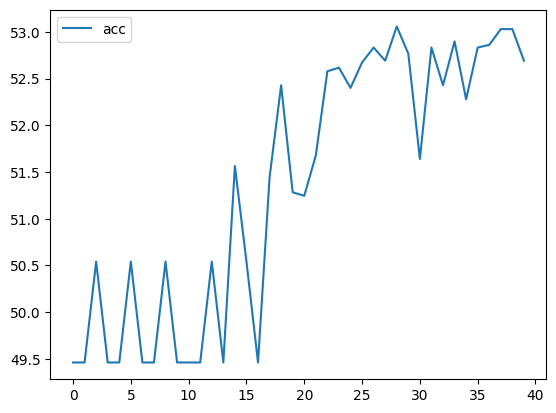

In [84]:
#plot acc
from matplotlib import pyplot as plt
plt.plot(test_acc_list,label='acc')
plt.legend()
plt.show()

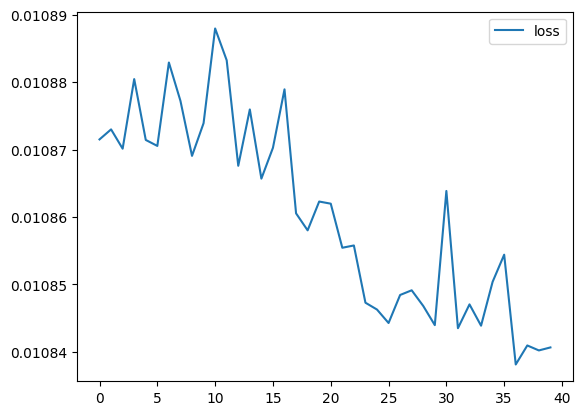

In [85]:
#plot loss
plt.plot(test_loss_list,label='loss')
plt.legend()
plt.show()

In [86]:
print(model(X_val[0].to(DEVICE)))
print(y_val[0])

tensor([-0.2096,  0.0436], grad_fn=<AddBackward0>)
tensor([0., 1.])


<AxesSubplot: >

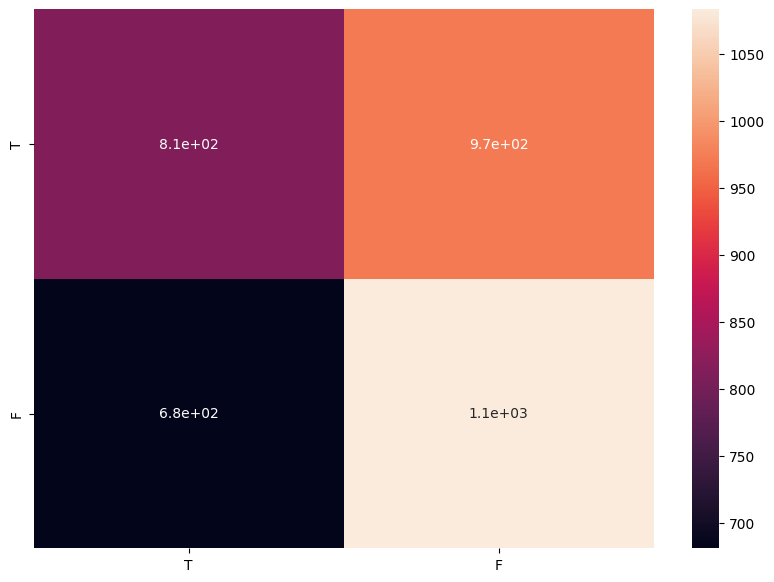

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model(X_val.to(DEVICE)).argmax(dim=1, keepdim=True)
y_true = y_val.argmax(1, keepdim=True).view_as(y_pred)
cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
df_cm = pd.DataFrame(cm, index = [i for i in "TF"],
                    columns = [i for i in "TF"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [88]:
a_cnt = 0
b_cnt = 0
for i in range(len(y_pred)):
    if y_pred[i][0] == 1:
        a_cnt += 1
    else:
        b_cnt += 1
print(f" a_cnt : {a_cnt} , b_cnt : {b_cnt}")

 a_cnt : 2053 , b_cnt : 1493


In [89]:
#save model
torch.save(model.state_dict(), 'CCV1.pt')

# 猜測

- 之前只能跑到51 ~ 49 是因為模型太大，但是資料太小，所以會發生指輸出都是一個類別的情況。 解決方法是把模型縮小，或是把資料增加。
    - 模型條小 -> 10 層 -> 4 層 51~49 -> 52~51

In [49]:

model3 = CCV3().to(DEVICE)
optimizer = optim.SGD(model3.parameters(), lr=0.05,momentum=0.5)
criterion = F.cross_entropy

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train(model3, train_loader, optimizer, criterion, epoch, DEVICE)
    test_acc, test_loss = test(model3, test_loader, criterion, DEVICE)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 1 [0/21279 (0%)]	Loss: 0.686946
Train Epoch: 1 [6400/21279 (30%)]	Loss: 0.688877
Train Epoch: 1 [12800/21279 (60%)]	Loss: 0.702374
Train Epoch: 1 [19200/21279 (90%)]	Loss: 0.694165
Test set: Average loss: 0.0109, Accuracy: 5263/10641 (49%)
data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 2 [0/21279 (0%)]	Loss: 0.677262
Train Epoch: 2 [6400/21279 (30%)]	Loss: 0.687823
Train Epoch: 2 [12800/21279 (60%)]	Loss: 0.697502
Train Epoch: 2 [19200/21279 (90%)]	Loss: 0.688600
Test set: Average loss: 0.0109, Accuracy: 5507/10641 (52%)
data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 3 [0/21279 (0%)]	Loss: 0.683641
Train Epoch: 3 [6400/21279 (30%)]	Loss: 0.694811
Train Epoch: 3 [12800/21279 (60%)]	Loss: 0.696690
Train Epoch: 3 [19200/21279 (90%)]	

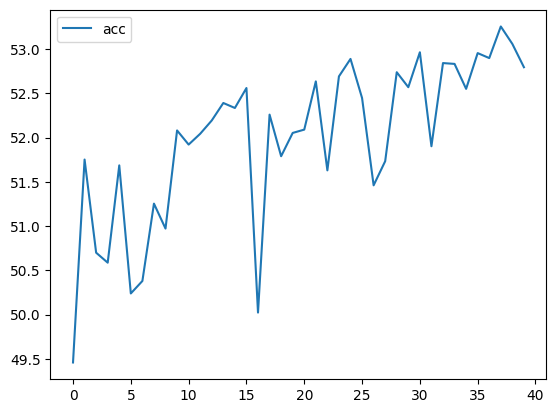

In [50]:
#plot acc
from matplotlib import pyplot as plt
plt.plot(test_acc_list,label='acc')
plt.legend()
plt.show()

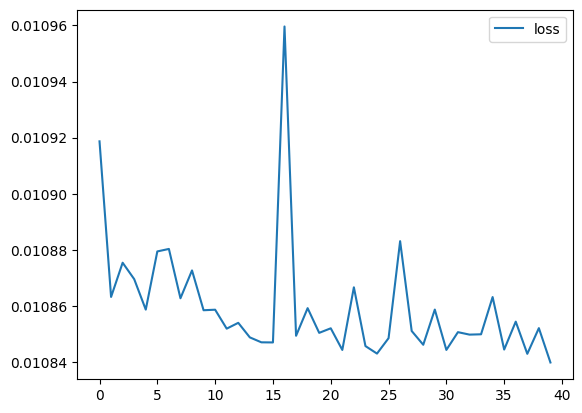

In [51]:
#plot loss
plt.plot(test_loss_list,label='loss')
plt.legend()
plt.show()

<AxesSubplot: >

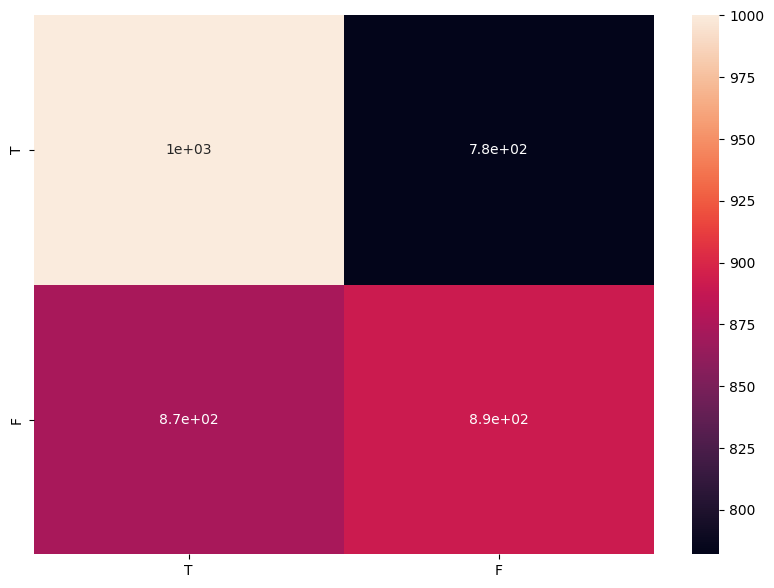

In [52]:
#confusion matrix
#TT TF
#FT FF
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model3(X_val.to(DEVICE)).argmax(dim=1, keepdim=True)
y_true = y_val.argmax(1, keepdim=True).view_as(y_pred)
cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
df_cm = pd.DataFrame(cm, index = [i for i in "TF"],
                    columns = [i for i in "TF"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [53]:
a_cnt = 0
b_cnt = 0
for i in range(len(y_pred)):
    if y_pred[i][0] == 1:
        a_cnt += 1
    else:
        b_cnt += 1
print(f" UP : {a_cnt} , DOWN : {b_cnt}")

 UP : 1673 , DOWN : 1873


In [55]:
#save model
torch.save(model3.state_dict(), 'CCV3.pt')

In [79]:
model5 = CCV5().to(DEVICE)
optimizer = optim.SGD(model5.parameters(), lr=0.05,momentum=0.5)
criterion = F.cross_entropy

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train(model5, train_loader, optimizer, criterion, epoch, DEVICE)
    test_acc, test_loss = test(model5, test_loader, criterion, DEVICE)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 1 [0/21279 (0%)]	Loss: 0.692774
Train Epoch: 1 [6400/21279 (30%)]	Loss: 0.692683
Train Epoch: 1 [12800/21279 (60%)]	Loss: 0.690307
Train Epoch: 1 [19200/21279 (90%)]	Loss: 0.686930
Test set: Average loss: 0.0109, Accuracy: 5263/10641 (49%)
data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 2 [0/21279 (0%)]	Loss: 0.693157
Train Epoch: 2 [6400/21279 (30%)]	Loss: 0.694501
Train Epoch: 2 [12800/21279 (60%)]	Loss: 0.695806
Train Epoch: 2 [19200/21279 (90%)]	Loss: 0.692798
Test set: Average loss: 0.0109, Accuracy: 5263/10641 (49%)
data shape: torch.Size([64, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 3 [0/21279 (0%)]	Loss: 0.686712
Train Epoch: 3 [6400/21279 (30%)]	Loss: 0.695675
Train Epoch: 3 [12800/21279 (60%)]	Loss: 0.693273
Train Epoch: 3 [19200/21279 (90%)]	

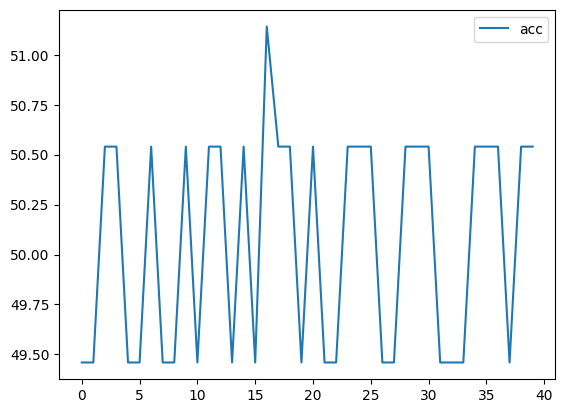

In [80]:
plt.plot(test_acc_list,label='acc')
plt.legend()
plt.show()

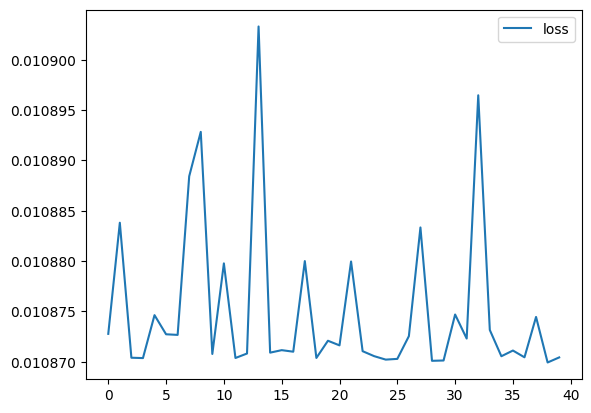

In [81]:
#plot loss
plt.plot(test_loss_list,label='loss')
plt.legend()
plt.show()

<AxesSubplot: >

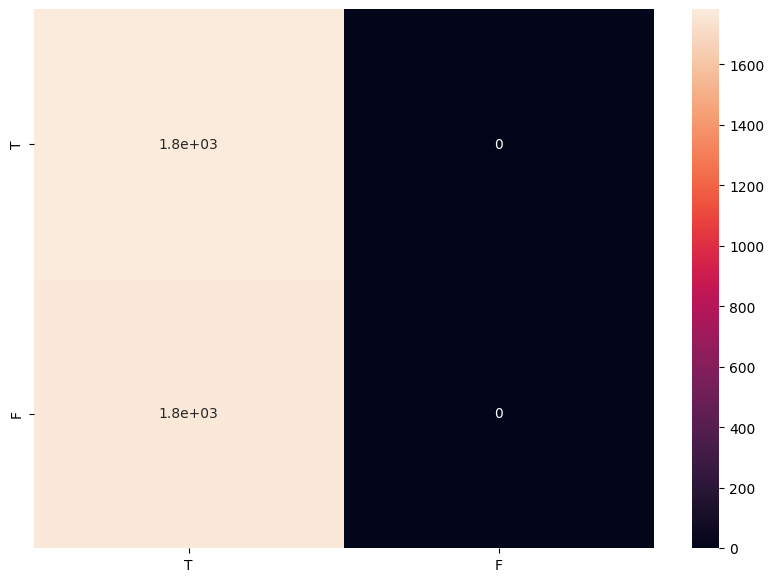

In [82]:
y_pred = model5(X_val.to(DEVICE)).argmax(dim=1, keepdim=True)
y_true = y_val.argmax(1, keepdim=True).view_as(y_pred)
cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
df_cm = pd.DataFrame(cm, index = [i for i in "TF"],
                    columns = [i for i in "TF"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [90]:
#save model
torch.save(model5.state_dict(), 'CCV5.pt')